## Load the Library

In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, scorer
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def llfun(act, pred):
    """ Logloss function for 1/0 probability
    """
    return (-(~(act == pred)).astype(int) * math.log(1e-15)).sum() / len(act)

## Load the Data

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Data Exploration

In [4]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test],ignore_index=True)
print(train.shape, test.shape, data.shape)

(68353, 13) (45978, 12) (114331, 13)


In [5]:
data.head()

,Customer_Location,Email_Campaign_Type,Email_ID,Email_Source_Type,Email_Status,Email_Type,Subject_Hotness_Score,Time_Email_sent_Category,Total_Images,Total_Links,Total_Past_Communications,Word_Count,source
0,E,2,EMA00081000034500,2,0.0,1,2.2,1,0.0,8.0,33.0,440,train
1,NaN,2,EMA00081000045360,1,0.0,2,2.1,2,0.0,5.0,15.0,504,train
2,B,3,EMA00081000066290,1,1.0,2,0.1,2,0.0,5.0,36.0,962,train
3,E,2,EMA00081000076560,2,0.0,1,3.0,2,0.0,16.0,25.0,610,train
4,C,3,EMA00081000109720,2,0.0,1,0.0,2,0.0,4.0,18.0,947,train


### Missing Data

In [6]:
data.apply(lambda x: sum(x.isnull()))

Customer_Location            19438
Email_Campaign_Type              0
Email_ID                         0
Email_Source_Type                0
Email_Status                 45978
Email_Type                       0
Subject_Hotness_Score            0
Time_Email_sent_Category         0
Total_Images                  2770
Total_Links                   3624
Total_Past_Communications    11515
Word_Count                       0
source                           0
dtype: int64

In [7]:
data.describe()

,Email_Campaign_Type,Email_Source_Type,Email_Status,Email_Type,Subject_Hotness_Score,Time_Email_sent_Category,Total_Images,Total_Links,Total_Past_Communications,Word_Count
count,114331.000000,114331.000000,68353.000000,114331.000000,114331.000000,114331.000000,111561.000000,110707.00000,102816.000000,114331.000000
mean,2.270539,1.456928,0.230934,1.284096,1.095876,1.997945,3.535178,10.41291,28.892225,701.350885
std,0.468056,0.498144,0.497032,0.450985,0.996247,0.631809,5.592399,6.39044,12.528849,271.875965
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.000000,40.000000
25%,2.000000,1.000000,0.000000,1.000000,0.200000,2.000000,0.000000,6.00000,20.000000,521.000000
50%,2.000000,1.000000,0.000000,1.000000,0.800000,2.000000,0.000000,9.00000,28.000000,694.000000
75%,3.000000,2.000000,0.000000,2.000000,1.800000,2.000000,5.000000,14.00000,38.000000,880.000000
max,3.000000,2.000000,2.000000,2.000000,5.000000,3.000000,47.000000,49.00000,67.000000,1316.000000


In [8]:
data.apply(lambda x: len(x.unique()))

Customer_Location                 9
Email_Campaign_Type               3
Email_ID                     114331
Email_Source_Type                 2
Email_Status                      4
Email_Type                        2
Subject_Hotness_Score            51
Time_Email_sent_Category          3
Total_Images                     47
Total_Links                      38
Total_Past_Communications        65
Word_Count                      151
source                            2
dtype: int64

## Data Cleaning

### One-Hot Encoding for
- 'Email_Campaign_Type', 
- 'Email_ID', 
- 'Email_Source_Type', 
- 'Email_Type', 
- 'Time_Email_sent_Category'

In [9]:
features_col_to_str = ['Email_Campaign_Type', 'Email_ID', 'Email_Source_Type', 'Email_Type', 'Time_Email_sent_Category']
for features in features_col_to_str:
    data[features] = data[features].astype(str)
data.dtypes

Customer_Location             object
Email_Campaign_Type           object
Email_ID                      object
Email_Source_Type             object
Email_Status                 float64
Email_Type                    object
Subject_Hotness_Score        float64
Time_Email_sent_Category      object
Total_Images                 float64
Total_Links                  float64
Total_Past_Communications    float64
Word_Count                     int64
source                        object
dtype: object

In [10]:
features_categ = ['Email_Campaign_Type', 'Email_Source_Type', 'Email_Type', 'Time_Email_sent_Category', ]
data_categ = data[features_categ]
data_categ = pd.get_dummies(data_categ)
data_categ.apply(lambda x: sum(x.isnull()))
data_categ.columns

Index(['Email_Campaign_Type_1', 'Email_Campaign_Type_2',
       'Email_Campaign_Type_3', 'Email_Source_Type_1', 'Email_Source_Type_2',
       'Email_Type_1', 'Email_Type_2', 'Time_Email_sent_Category_1',
       'Time_Email_sent_Category_2', 'Time_Email_sent_Category_3'],
      dtype='object')

In [11]:
data[data_categ.columns] = data_categ
data.drop(features_categ,axis=1,inplace=True)

In [12]:
data.columns

Index(['Customer_Location', 'Email_ID', 'Email_Status',
       'Subject_Hotness_Score', 'Total_Images', 'Total_Links',
       'Total_Past_Communications', 'Word_Count', 'source',
       'Email_Campaign_Type_1', 'Email_Campaign_Type_2',
       'Email_Campaign_Type_3', 'Email_Source_Type_1', 'Email_Source_Type_2',
       'Email_Type_1', 'Email_Type_2', 'Time_Email_sent_Category_1',
       'Time_Email_sent_Category_2', 'Time_Email_sent_Category_3'],
      dtype='object')

### Imputing 'Customer_Location'

In [13]:
#[x for x in data.values if x not in data[data['Customer_Location'].isnull()]]
#data[data['Customer_Location'].isnull()]
features_cl = ['Email_Campaign_Type_1', 'Email_Campaign_Type_2',
       'Email_Campaign_Type_3', 'Email_Source_Type_1', 'Email_Source_Type_2', 
        'Email_Type_1', 'Email_Type_2', 'Time_Email_sent_Category_1',
       'Time_Email_sent_Category_2', 'Time_Email_sent_Category_3', 
        'Subject_Hotness_Score', 'Word_Count']
target_cl = ['Customer_Location']

le = LabelEncoder()
data_cl = data[features_cl + target_cl].loc[data['Customer_Location'].isnull() == False]
X = data_cl[features_cl]
y = data_cl[target_cl]
y = le.fit_transform(y)

C:\Users\ranjank\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

[]

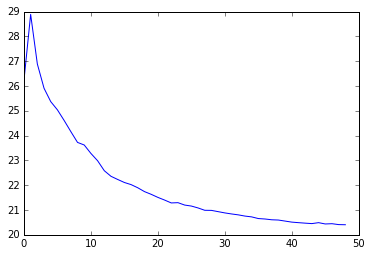

In [15]:
# Fit
logloss = []
for i in range(1, 50, 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    
    # Predict on test set
    outcome = knn.predict(X_test)
    
    # Logloss
    logloss.append(llfun(y_test, outcome))

plt.plot(logloss)
plt.plot()
#plt.savefig('n_neighbors_vs_logloss.png')

In [16]:
data_cl_predict = data[features_cl].loc[data['Customer_Location'].isnull() == True]

In [17]:
knn = KNeighborsClassifier(n_neighbors=47)
knn.fit(X, y)
data_cl_predicted = knn.predict(data_cl_predict)
data_cl_predicted = le.inverse_transform(data_cl_predicted)

In [18]:
data_cl_predict.head()

,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3,Email_Source_Type_1,Email_Source_Type_2,Email_Type_1,Email_Type_2,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3,Subject_Hotness_Score,Word_Count
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.1,504
15,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.9,694
21,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.1,684
28,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.8,339
35,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,4.2,254


In [19]:
data_cl_predict.loc[:,'Customer_Location'] = pd.Series(data_cl_predicted, index=data_cl_predict.index)

In [20]:
data_cl_predict.apply(lambda x: sum(x.isnull()))
data_cl_predict.head()

,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3,Email_Source_Type_1,Email_Source_Type_2,Email_Type_1,Email_Type_2,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3,Subject_Hotness_Score,Word_Count,Customer_Location
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.1,504,G
15,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.9,694,G
21,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.1,684,G
28,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.8,339,G
35,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,4.2,254,G


In [21]:
data.columns

Index(['Customer_Location', 'Email_ID', 'Email_Status',
       'Subject_Hotness_Score', 'Total_Images', 'Total_Links',
       'Total_Past_Communications', 'Word_Count', 'source',
       'Email_Campaign_Type_1', 'Email_Campaign_Type_2',
       'Email_Campaign_Type_3', 'Email_Source_Type_1', 'Email_Source_Type_2',
       'Email_Type_1', 'Email_Type_2', 'Time_Email_sent_Category_1',
       'Time_Email_sent_Category_2', 'Time_Email_sent_Category_3'],
      dtype='object')

In [22]:
data3 = data_cl.append(data_cl_predict)

### One-Hot Encoding for 
- 'Customer_Location'

In [23]:
data3 = pd.get_dummies(data3)

In [24]:
data.columns

Index(['Customer_Location', 'Email_ID', 'Email_Status',
       'Subject_Hotness_Score', 'Total_Images', 'Total_Links',
       'Total_Past_Communications', 'Word_Count', 'source',
       'Email_Campaign_Type_1', 'Email_Campaign_Type_2',
       'Email_Campaign_Type_3', 'Email_Source_Type_1', 'Email_Source_Type_2',
       'Email_Type_1', 'Email_Type_2', 'Time_Email_sent_Category_1',
       'Time_Email_sent_Category_2', 'Time_Email_sent_Category_3'],
      dtype='object')

In [25]:
data3.columns

Index(['Email_Campaign_Type_1', 'Email_Campaign_Type_2',
       'Email_Campaign_Type_3', 'Email_Source_Type_1', 'Email_Source_Type_2',
       'Email_Type_1', 'Email_Type_2', 'Time_Email_sent_Category_1',
       'Time_Email_sent_Category_2', 'Time_Email_sent_Category_3',
       'Subject_Hotness_Score', 'Word_Count', 'Customer_Location_A',
       'Customer_Location_B', 'Customer_Location_C', 'Customer_Location_D',
       'Customer_Location_E', 'Customer_Location_F', 'Customer_Location_G',
       'Customer_Location_H'],
      dtype='object')

In [26]:
remaining_columns = ['Email_ID', 'Email_Status', 'Total_Images', 'Total_Links', 'Total_Past_Communications', 'source']
remaining_columns

['Email_ID',
 'Email_Status',
 'Total_Images',
 'Total_Links',
 'Total_Past_Communications',
 'source']

In [27]:
data3[remaining_columns] = data[remaining_columns]

In [28]:
data3.head()

,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3,Email_Source_Type_1,Email_Source_Type_2,Email_Type_1,Email_Type_2,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3,...,Customer_Location_E,Customer_Location_F,Customer_Location_G,Customer_Location_H,Email_ID,Email_Status,Total_Images,Total_Links,Total_Past_Communications,source
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,EMA00081000034500,0.0,0.0,8.0,33.0,train
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,EMA00081000066290,1.0,0.0,5.0,36.0,train
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,EMA00081000076560,0.0,0.0,16.0,25.0,train
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,EMA00081000109720,0.0,0.0,4.0,18.0,train
5,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,EMA00081000131660,0.0,0.0,11.0,NaN,train


In [29]:
data3.apply(lambda x: sum(x.isnull()))

Email_Campaign_Type_1             0
Email_Campaign_Type_2             0
Email_Campaign_Type_3             0
Email_Source_Type_1               0
Email_Source_Type_2               0
Email_Type_1                      0
Email_Type_2                      0
Time_Email_sent_Category_1        0
Time_Email_sent_Category_2        0
Time_Email_sent_Category_3        0
Subject_Hotness_Score             0
Word_Count                        0
Customer_Location_A               0
Customer_Location_B               0
Customer_Location_C               0
Customer_Location_D               0
Customer_Location_E               0
Customer_Location_F               0
Customer_Location_G               0
Customer_Location_H               0
Email_ID                          0
Email_Status                  45978
Total_Images                   2770
Total_Links                    3624
Total_Past_Communications     11515
source                            0
dtype: int64

### Imputing 
- 'Total_Past_Communications' 

In [30]:
data3.dtypes

Email_Campaign_Type_1         float64
Email_Campaign_Type_2         float64
Email_Campaign_Type_3         float64
Email_Source_Type_1           float64
Email_Source_Type_2           float64
Email_Type_1                  float64
Email_Type_2                  float64
Time_Email_sent_Category_1    float64
Time_Email_sent_Category_2    float64
Time_Email_sent_Category_3    float64
Subject_Hotness_Score         float64
Word_Count                      int64
Customer_Location_A           float64
Customer_Location_B           float64
Customer_Location_C           float64
Customer_Location_D           float64
Customer_Location_E           float64
Customer_Location_F           float64
Customer_Location_G           float64
Customer_Location_H           float64
Email_ID                       object
Email_Status                  float64
Total_Images                  float64
Total_Links                   float64
Total_Past_Communications     float64
source                         object
dtype: objec

In [31]:
features_tpc = ['Email_Campaign_Type_1', 'Email_Campaign_Type_2',
       'Email_Campaign_Type_3', 'Email_Source_Type_1', 'Email_Source_Type_2', 
        'Email_Type_1', 'Email_Type_2', 'Time_Email_sent_Category_1',
       'Time_Email_sent_Category_2', 'Time_Email_sent_Category_3', 
        'Subject_Hotness_Score', 'Word_Count', 'Customer_Location_A',
       'Customer_Location_B', 'Customer_Location_C', 'Customer_Location_D',
       'Customer_Location_E', 'Customer_Location_F', 'Customer_Location_G',
       'Customer_Location_H']
target_tpc = ['Total_Past_Communications']

data_tpc = data3[features_tpc + target_tpc].loc[data3['Total_Past_Communications'].isnull() == False]
X = data_tpc[features_tpc]
y = data_tpc[target_tpc]

In [32]:
print(X.shape, y.shape)

(102816, 20) (102816, 1)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(82252, 20) (20564, 20) (82252, 1) (20564, 1)


C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A c

[]

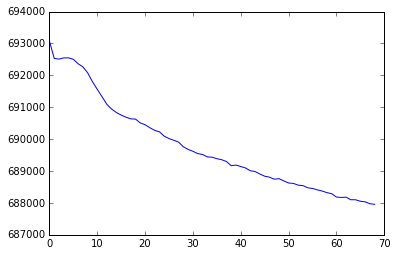

In [34]:
# Fit
logloss = []
for i in range(1, 70, 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    
    # Predict on test set
    outcome = knn.predict(X_test)
 
    # Logloss
    logloss.append(llfun(y_test.values.tolist(), outcome))

plt.plot(logloss)
plt.plot()
#plt.savefig('n_neighbors_vs_logloss.png')

In [35]:
data_tpc_predict = data3[features_tpc].loc[data3['Total_Past_Communications'].isnull() == True]

In [36]:
knn = KNeighborsClassifier(n_neighbors=70)
knn.fit(X, y)
data_tpc_predicted = knn.predict(data_tpc_predict)

C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app


In [37]:
data_tpc_predict.loc[:,'Total_Past_Communications'] = pd.Series(data_tpc_predicted, index=data_tpc_predict.index)

In [38]:
data_tpc_predict.head()

,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3,Email_Source_Type_1,Email_Source_Type_2,Email_Type_1,Email_Type_2,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3,...,Word_Count,Customer_Location_A,Customer_Location_B,Customer_Location_C,Customer_Location_D,Customer_Location_E,Customer_Location_F,Customer_Location_G,Customer_Location_H,Total_Past_Communications
5,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,416,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,35.0
8,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,655,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,29.0
17,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1061,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,31.0
27,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,704,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.0
29,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,988,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.0


In [39]:
data4 = data_tpc.append(data_tpc_predict)
data4[['Email_ID', 'Email_Status', 'Total_Images', 'Total_Links']] = data3[['Email_ID', 'Email_Status', 'Total_Images', 'Total_Links']]

In [40]:
data4

,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3,Email_Source_Type_1,Email_Source_Type_2,Email_Type_1,Email_Type_2,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3,...,Customer_Location_D,Customer_Location_E,Customer_Location_F,Customer_Location_G,Customer_Location_H,Total_Past_Communications,Email_ID,Email_Status,Total_Images,Total_Links
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,33.0,EMA00081000034500,0.0,0.0,8.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,36.0,EMA00081000066290,1.0,0.0,5.0
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,25.0,EMA00081000076560,0.0,0.0,16.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.0,EMA00081000109720,0.0,0.0,4.0
6,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,34.0,EMA00081000160500,0.0,0.0,4.0
7,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,21.0,EMA00081000269630,0.0,2.0,6.0
9,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,40.0,EMA00081000367310,0.0,0.0,11.0
10,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,27.0,EMA00081000428660,0.0,0.0,6.0
11,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,24.0,EMA00081000583620,0.0,16.0,21.0
12,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,42.0,EMA00081000591290,0.0,0.0,6.0


### Imputing
- 'Total_Images'
- 'Total_Links'

In [41]:
features_missing_values = ['Total_Images','Total_Links']
data_missing_values = data4[features_missing_values]
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
data_missing_values_array = imputer.fit_transform(data_missing_values)
data_missing_values = pd.DataFrame(data_missing_values_array, index=data_missing_values.index, columns=data_missing_values.columns)
data_missing_values

,Total_Images,Total_Links
0,0.000000,8.00000
2,0.000000,5.00000
3,0.000000,16.00000
4,0.000000,4.00000
6,0.000000,4.00000
7,2.000000,6.00000
9,0.000000,11.00000
10,0.000000,6.00000
11,16.000000,21.00000
12,0.000000,6.00000


In [42]:
data4[features_missing_values] = data_missing_values[features_missing_values]
data4.head()

,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3,Email_Source_Type_1,Email_Source_Type_2,Email_Type_1,Email_Type_2,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3,...,Customer_Location_D,Customer_Location_E,Customer_Location_F,Customer_Location_G,Customer_Location_H,Total_Past_Communications,Email_ID,Email_Status,Total_Images,Total_Links
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,33.0,EMA00081000034500,0.0,0.0,8.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,36.0,EMA00081000066290,1.0,0.0,5.0
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,25.0,EMA00081000076560,0.0,0.0,16.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.0,EMA00081000109720,0.0,0.0,4.0
6,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,34.0,EMA00081000160500,0.0,0.0,4.0


In [43]:
data3.apply(lambda x: sum(x.isnull()))

Email_Campaign_Type_1             0
Email_Campaign_Type_2             0
Email_Campaign_Type_3             0
Email_Source_Type_1               0
Email_Source_Type_2               0
Email_Type_1                      0
Email_Type_2                      0
Time_Email_sent_Category_1        0
Time_Email_sent_Category_2        0
Time_Email_sent_Category_3        0
Subject_Hotness_Score             0
Word_Count                        0
Customer_Location_A               0
Customer_Location_B               0
Customer_Location_C               0
Customer_Location_D               0
Customer_Location_E               0
Customer_Location_F               0
Customer_Location_G               0
Customer_Location_H               0
Email_ID                          0
Email_Status                  45978
Total_Images                   2770
Total_Links                    3624
Total_Past_Communications     11515
source                            0
dtype: int64

### Scale the data

In [44]:
features_data2b_scale = ['Subject_Hotness_Score', 'Word_Count', 'Total_Images', 'Total_Links', 'Total_Past_Communications']
data_data2b_scale = data4[features_data2b_scale]
ss = StandardScaler()
data_data2b_scale_array = ss.fit_transform(data_data2b_scale)
data_data2b_scale = pd.DataFrame(data_data2b_scale_array, index=data_data2b_scale.index, columns=data_data2b_scale.columns)
data4[features_data2b_scale] = data_data2b_scale
data4.head()

,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3,Email_Source_Type_1,Email_Source_Type_2,Email_Type_1,Email_Type_2,Time_Email_sent_Category_1,Time_Email_sent_Category_2,Time_Email_sent_Category_3,...,Customer_Location_D,Customer_Location_E,Customer_Location_F,Customer_Location_G,Customer_Location_H,Total_Past_Communications,Email_ID,Email_Status,Total_Images,Total_Links
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.323429,EMA00081000034500,0.0,-0.639942,-0.383713
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.565563,EMA00081000066290,1.0,-0.639942,-0.860788
3,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.322262,EMA00081000076560,0.0,-0.639942,0.888488
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.887242,EMA00081000109720,0.0,-0.639942,-1.019814
6,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.404140,EMA00081000160500,0.0,-0.639942,-1.019814


In [50]:
data4['source'] = data3['source']

In [51]:
#Divide into test and train:
train = data4.loc[data['source']=="train"]
test = data4.loc[data['source']=="test"]

In [52]:
test.apply(lambda x: sum(x.isnull()))

Email_Campaign_Type_1             0
Email_Campaign_Type_2             0
Email_Campaign_Type_3             0
Email_Source_Type_1               0
Email_Source_Type_2               0
Email_Type_1                      0
Email_Type_2                      0
Time_Email_sent_Category_1        0
Time_Email_sent_Category_2        0
Time_Email_sent_Category_3        0
Subject_Hotness_Score             0
Word_Count                        0
Customer_Location_A               0
Customer_Location_B               0
Customer_Location_C               0
Customer_Location_D               0
Customer_Location_E               0
Customer_Location_F               0
Customer_Location_G               0
Customer_Location_H               0
Total_Past_Communications         0
Email_ID                          0
Email_Status                  45978
Total_Images                      0
Total_Links                       0
source                            0
dtype: int64

In [53]:
#Drop unnecessary columns:
test.drop(['Email_Status','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\ranjank\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [57]:
len(test)

45978

In [58]:
#Export files as modified versions:
train.to_csv("train_modified3.csv",index=False)
test.to_csv("test_modified3.csv",index=False)